## Time Series

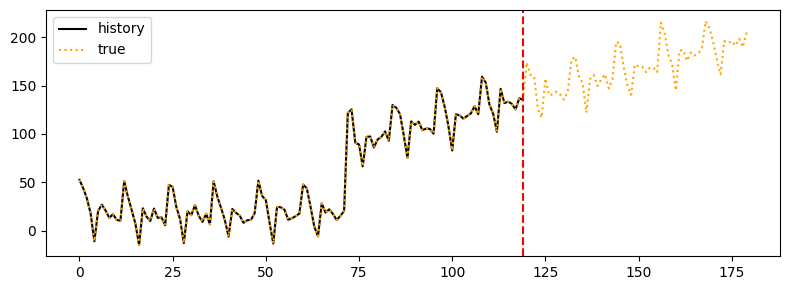

In [1]:
import numpy as np
np.random.seed(seed=42)
import matplotlib.pyplot as plt
import seaborn as sns

def trend(time):
    slope = np.zeros_like(a=time)
    slope[time < (3*12)] = 0.2
    slope[(time >= (3*12)) & (time < (6*12))] = -0.4
    slope[time >= (6*12)] = 1.0
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi),
        1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / float(period)
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=5):
    rnd = np.random.RandomState(seed=42)
    return rnd.randn(len(time)) * noise_level

period = 12; baseline = 10; amplitude = 40

time_history = np.arange(10*12)
ts_history = baseline + trend(time=time_history)\
    + seasonality(time=time_history, period=period, amplitude=amplitude)\
    + noise(time=time_history)
ts_history = ts_history.astype(np.float32)

time_true = np.arange(15*12)
ts_true = baseline + trend(time=time_true)\
    + seasonality(time=time_true, period=period, amplitude=amplitude)\
    + noise(time=time_true)
ts_true = ts_true.astype(np.float32)

plt.figure(figsize=(8, 3))
sns.lineplot(x=time_history, y=ts_history, label='history', color='black')
sns.lineplot(x=time_true, y=ts_true, label='true', color='orange',
    linestyle=':')
plt.axvline(x=time_history[-1], color='red', linestyle='--')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Dataset & DataLoader

In [7]:
from statsmodels.tsa import seasonal
import matplotlib.pyplot as plt
import seaborn as sns

tsa = seasonal.STL(endog=ts_history, period=12).fit()
ts_noresid = tsa.trend + tsa.seasonal

plt.figure(figsize=(8, 3))
sns.lineplot(x=time_history, y=ts_history, label='history', color='black')
sns.lineplot(x=time_history, y=ts_noresid, label='no_resid', color='orange')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'statsmodels'

In [2]:
from sklearn import preprocessing
import torch
torch.manual_seed(seed=42)

x_len = 24; y_len = 1
ts_train = ts_history[:-12]
ts_test = ts_history[-(x_len+12):]

scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
ts_train = scaler.fit_transform(X=ts_train.reshape(-1, 1)).flatten()
ts_test = scaler.transform(X=ts_test.reshape(-1, 1)).flatten()

class TrainingDataset(torch.utils.data.Dataset):
    def __init__(self, ts, x_len, y_len):
        super().__init__()
        self.ts = torch.tensor(data=ts, dtype=torch.float32)
        self.x_len = x_len; self.y_len = y_len
        self.indices = list(range(len(ts) - (x_len + y_len) + 1))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        x = self.ts[i : i + self.x_len]
        y = self.ts[i + self.x_len : i + self.x_len + self.y_len]
        return x, y

batch_size = 16
ds_train = TrainingDataset(ts=ts_train, x_len=x_len, y_len=y_len)
dl_train = torch.utils.data.DataLoader(dataset=ds_train, shuffle=True,
    batch_size=batch_size)

ds_test = TrainingDataset(ts=ts_test, x_len=x_len, y_len=y_len)
dl_test = torch.utils.data.DataLoader(dataset=ds_test, shuffle=False,
    batch_size=batch_size)

x, y = next(iter(dl_test))
print(x.shape, y.shape)

torch.Size([12, 24]) torch.Size([12, 1])


## Model

In [3]:
import numpy as np
import torch
torch.manual_seed(seed=42)

class TrendBlock(torch.nn.Module):
    def __init__(self, x_len, y_len, hidden_dim, degree=2):
        super().__init__()
        self.x_len = x_len
        self.y_len = y_len
        self.degree = degree
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(in_features=x_len, out_features=hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=hidden_dim, out_features=degree+1)
        )

    def forward(self, x):
        theta = self.fc(x)
        t_back = torch.linspace(start=0, end=1, steps=self.x_len, device=x.device)
        t_fore = torch.linspace(start=1, end=1+self.y_len/self.x_len,
            steps=self.y_len, device=x.device)
        backcast = sum(theta[:, i:i+1]*t_back**i for i in range(self.degree+1))
        forecast = sum(theta[:, i:i+1]*t_fore**i for i in range(self.degree+1))
        
        return backcast, forecast

class SeasonalityBlock(torch.nn.Module):
    def __init__(self, x_len, y_len, hidden_dim, harmonics=6):
        super().__init__()
        self.x_len = x_len
        self.y_len = y_len
        self.harmonics = harmonics
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(in_features=x_len, out_features=hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=hidden_dim, out_features=2*harmonics)
        )

    def forward(self, x):
        theta = self.fc(x)
        t_back = torch.arange(end=self.x_len, device=x.device)
        t_fore = torch.arange(start=self.x_len, end=self.x_len + self.y_len,
            device=x.device)

        backcast = 0
        forecast = 0
        for i in range(self.harmonics):
            backcast += theta[:, 2*i:2*i+1]*torch.sin(2*np.pi*(i+1)*t_back/12)
            backcast += theta[:, 2*i+1:2*i+2]*torch.cos(2*np.pi*(i+1)*t_back/12)

            forecast += theta[:, 2*i:2*i+1]*torch.sin(2*np.pi*(i+1)*t_fore/12)
            forecast += theta[:, 2*i+1:2*i+2]*torch.cos(2*np.pi*(i+1)*t_fore/12)

        return backcast, forecast

class TimeSeriesForecast(torch.nn.Module):
    def __init__(self, x_len, y_len):
        super().__init__()
        self.trend1 = TrendBlock(x_len, y_len, hidden_dim=128)
        self.trend2 = TrendBlock(x_len, y_len, hidden_dim=128)
        self.season1 = SeasonalityBlock(x_len, y_len, hidden_dim=128)
        self.season2 = SeasonalityBlock(x_len, y_len, hidden_dim=128)

    def forward(self, x):
        residual = x
        y_pred = 0

        for block in [self.trend1, self.season1, self.trend2, self.season2]:
            backcast, forecast = block(residual)
            residual = residual - backcast
            y_pred = y_pred + forecast

        return y_pred
                                
model = TimeSeriesForecast(x_len=x_len, y_len=y_len)
total_params = sum(p.numel() for p in model.parameters())
print("Total model parameters: %d"%(total_params))

y_pred = model(x=x)
y_pred.shape

Total model parameters: 53854


torch.Size([12, 1])

## Training

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
torch.manual_seed(seed=42)

def train_step(model, dl_train, loss_fn, optimizer, device):
    model.train()
    losses = []
    for x, y in dl_train:
        x, y = x.to(device), y.to(device)
        y_pred = model(x=x)
        loss = loss_fn(input=y_pred, target=y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    return np.mean(losses)

@torch.no_grad()
def test_step(model, dl_test, loss_fn, device):
    model.eval()
    losses = []
    for x, y in dl_test:
        x, y = x.to(device), y.to(device)
        y_pred = model(x=x)
        loss = loss_fn(input=y_pred, target=y)
        losses.append(loss.item())
    
    return np.mean(losses)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
        elif loss < (self.best_loss - self.min_delta):
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def plot_history(history):
    df_history = pd.DataFrame(history)
    df_history.index.name = 'epoch'
    df_history.reset_index(inplace=True)

    plt.figure(figsize=(8, 3))
    sns.lineplot(data=df_history, x='epoch', y='train_loss', label='train')
    sns.lineplot(data=df_history, x='epoch', y='test_loss', label='test')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.title(label="loss vs. epoch")
    plt.xlabel(xlabel='epoch')
    plt.ylabel(ylabel='loss (log scale)')
    plt.tight_layout()
    plt.show()

Training finished in 19.01s, best_loss=inf


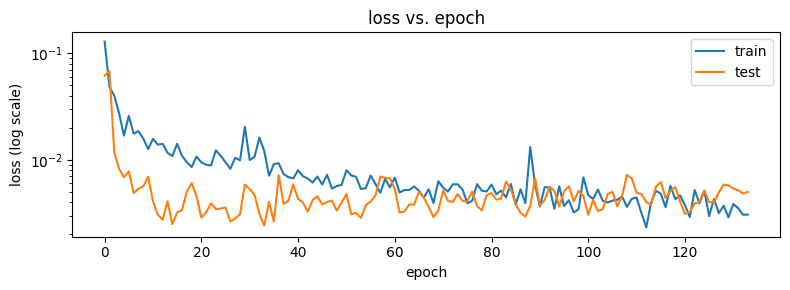

In [5]:
import os
import time
import pandas as pd
import torch
torch.manual_seed(seed=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TimeSeriesForecast(x_len=x_len, y_len=y_len).to(device)
loss_fn = torch.nn.SmoothL1Loss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3,
    weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
    mode='min', factor=0.9, patience=10)
early_stopping = EarlyStopping(patience=100, min_delta=1e-6)

num_epochs = 1000
os.makedirs('models', exist_ok=True)
model_path = 'models/timeseries_forecast.pth'

history = {'train_loss': [], 'test_loss': []}
best_loss = float('inf')
start_time = time.time()
for epoch in range(num_epochs):

    train_loss = train_step(model=model, dl_train=dl_train, loss_fn=loss_fn,
        optimizer=optimizer, device=device)
    history['train_loss'].append(train_loss)

    test_loss = test_step(model=model, dl_test=dl_test, loss_fn=loss_fn,
        device=device)
    history['test_loss'].append(test_loss)

    scheduler.step(metrics=train_loss)

    # if test_loss < best_loss:
    #     best_loss = test_loss
    #     torch.save(obj=model.state_dict(), f=model_path)

    early_stopping(loss=test_loss)
    if early_stopping.early_stop:
        break

torch.save(obj=model.state_dict(), f=model_path)
total_time = time.time() - start_time
print("Training finished in %.2fs, best_loss=%.6f"%(total_time, best_loss))

plot_history(history=history)

## Forecasting

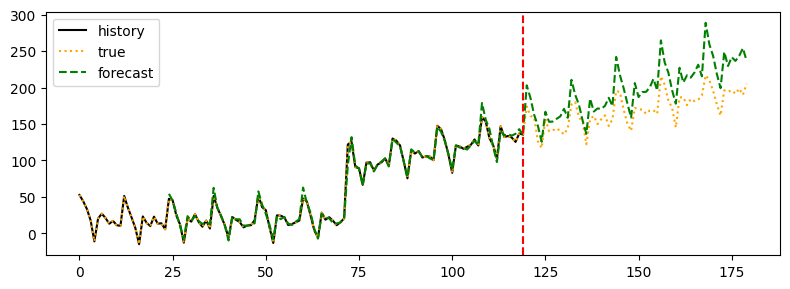

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
torch.manual_seed(seed=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def forecast(model, ts, x_len, steps=5*12):
    model.eval()
    preds = []
    
    idx = np.arange(stop=len(ts)-x_len).reshape(-1, 1) + np.arange(stop=x_len)
    x = torch.tensor(data=ts[idx], dtype=torch.float32).to(device)
    with torch.no_grad():
        pred = model(x=x)
    preds.append(pred)

    x_last = ts[-x_len:].copy()
    for _ in range(steps):
        x = torch.tensor(data=x_last, dtype=torch.float32)\
            .unsqueeze(dim=0).to(device)
        with torch.no_grad():
            pred = model(x=x)
        preds.append(pred)
        x_last = np.roll(x_last, -1)
        x_last[-1] = pred
    
    return torch.cat(tensors=preds).cpu().squeeze()

model = TimeSeriesForecast(x_len=x_len, y_len=y_len).to(device)
model.load_state_dict(torch.load(f=model_path, weights_only=True))

ts_scaled = scaler.transform(X=ts_history.reshape(-1, 1)).flatten()
preds = forecast(model=model, ts=ts_scaled, x_len=x_len)
ts_pred = scaler.inverse_transform(X=preds.reshape(-1, 1)).flatten()
time_pred = np.arange(start=(x_len+y_len-1),
    stop=(x_len+y_len-1) + len(ts_pred))

plt.figure(figsize=(8, 3))
sns.lineplot(x=time_history, y=ts_history, label='history', color='black')
sns.lineplot(x=time_true, y=ts_true, label='true', color='orange', linestyle=':')
sns.lineplot(x=time_pred, y=ts_pred, label='forecast', color='green', linestyle='--')
plt.axvline(x=time_history[-1], color='red', linestyle='--')
plt.legend(loc='best')
plt.tight_layout()
plt.show()